In [1]:
%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#### Utility Functions

In [142]:
## What about lagged variables

# papa wants some lagged variables

def lag(data, lag, cols_to_lag):
    d = data.copy()
    
    lags = []
    
    for i in cols_to_lag:
        lags.append(i + "_lagged_by_{}".format(lag))
    
    d[lags] = d.groupby("unit_id")[cols_to_lag].shift(lag)
    d.fillna(value=-99, inplace=True)
    return d


In [53]:
# get the RMSE of the results
def get_rmse(y_real, y_hat, label='test'):
    mse = mean_squared_error(y_real, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_real, y_hat)
    print('Dataset: {} RMSE:{}, R2:{}'.format(label, rmse, variance))

# adds the operating condition for the engine for each unit
# make a string to use as categorical variable
def add_op_co(df):
    op_co = df.copy()
    op_co['setting_1'] = op_co['setting_1'].round(decimals=1)
    op_co['setting_2'] = op_co['setting_2'].round(decimals=1)
    op_co['setting_3'] = op_co['setting_3'].round(decimals=1)
    op_co['op_cond'] = op_co['setting_1'].astype(str) + '-' + op_co['setting_2'].astype(str) + '-' + op_co['setting_3'].astype(str)
    return op_co

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

# need to remove noise from the signals
# https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
# https://stackoverflow.com/questions/60966612/how-to-use-exponential-smoothing-to-smooth-the-timeseries-in-python
# https://stackoverflow.com/questions/36511942/exponential-smoothing-function-issue-with-grouping-sizes
# did not implement as I did not really understand this, and didn't want to just use someone elses code
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    df[sensors] = df.groupby('unit_id')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # second, drop first n_samples of each unit_id to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_id')['unit_id'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

In [3]:
# sequence array generator for LSTM

# need to generate sequences for the LSTM to use
# Tensorflow has some functions for this, but not flexible enough to use with our dataset
# need custom generator because not all engines have sequences of the same size
# code adapted from --> https://github.com/Azure/lstms_for_predictive_maintenance
# https://realpython.com/introduction-to-python-generators/

def gen_train_seq(data, sequence_length, cols):
    data_out = data[cols].values
    size = data_out.shape[0]
    for start, stop in zip(range(0, size - (sequence_length-1)), range(sequence_length, size+1)):
        yield data_out[start:stop, :]
          
def label_generator(data, sequence_length, labels):
    data_out = data[labels].values
    size = data_out.shape[0]
    return data_out[sequence_length-1:size, :]

def test_padding(data, sequence_length, cols, m):
    size = data.shape[0]
    
    if size < sequence_length: # add padding of dummy nums
        padding = np.full(shape = ((sequence_length - size), len(cols)), fill_value = m)
        output = np.concatenate((padding, data[cols].values))
    else:
        output = data[cols].values
    
    # per predictive maintenance template we only want the last sequence from each test run
    #(https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2),
    
    stop = output.shape[0]
    start = stop - sequence_length
    
    for i in list(range(1)):
        yield(output[start:stop,:])
        
        

In [4]:
# import dataset!

dataset = "001"

training_file = 'CMAPSS_DATA/train_FD{}.txt'.format(dataset)
testing_file = 'CMAPSS_DATA/test_FD{}.txt'.format(dataset)
RUL_file = 'CMAPSS_DATA/RUL_FD{}.txt'.format(dataset)
index_names = ['unit_id', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names


train = pd.read_csv(training_file, sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv(testing_file, sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv(RUL_file, sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

print(train.shape)
train.head()


(20631, 26)


,unit_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
# need to attach the RUL for each cycle

# Get the max num of cycles for each unit & add to dataframe
group_by_unit = train.groupby(by="unit_id")
max_cycle = group_by_unit["time_cycles"].max()
RUL_column = train.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_id', right_index=True)
# for each row, get the difference from it to the max
remaining_useful_life = RUL_column["max_cycle"] - RUL_column["time_cycles"]
RUL_column["RUL"] = remaining_useful_life
# get rid of the max, dont need anymore
train = RUL_column.drop("max_cycle", axis=1)
train[index_names+['RUL']].head()

,unit_id,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


### Step 1: Try regular old regression!

In [6]:
# build up data for training the models

X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

# get last row of each engine
X_test = test.drop('time_cycles', axis=1).groupby('unit_id').last().copy() 

In [7]:


# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
get_rmse(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
get_rmse(y_test, y_hat_test)

Dataset: train RMSE:44.660359801722805, R2:0.5795961126406277
Dataset: test RMSE:32.04109478175181, R2:0.4054954961201451


Results are pretty not great compared to the LSTM paper, so hopefully there will be a pretty big improvement!

In [54]:
X_train_condition = add_op_co(train)
X_test_condition = add_op_co(X_test)

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

X_train_condition.head()
X_train_condition

,unit_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,op_cond
0,1,1,-0.0,-0.0,100.0,0.0,-1.711745,-0.135105,-0.911228,-1.0,...,-0.275970,-0.588674,-1.0,-0.786158,0.0,0.0,1.343200,1.187088,125,-0.0--0.0-100.0
1,1,2,0.0,-0.0,100.0,0.0,-1.062708,0.231118,-0.626194,-1.0,...,-0.660992,-0.261707,-1.0,-0.754587,0.0,0.0,0.999187,1.223949,125,0.0--0.0-100.0
2,1,3,-0.0,0.0,100.0,0.0,-0.663910,-0.412992,-0.515235,-1.0,...,-0.556882,-0.657145,-1.0,-2.082607,0.0,0.0,0.743954,0.492172,125,-0.0-0.0-100.0
3,1,4,0.0,0.0,100.0,0.0,-0.672971,-1.278257,-0.824098,-1.0,...,-0.501357,-1.990018,-1.0,-0.803314,0.0,0.0,0.371202,0.804103,125,0.0-0.0-100.0
4,1,5,-0.0,-0.0,100.0,0.0,-0.609676,-1.237412,-0.295082,-1.0,...,-0.522953,-0.326347,-1.0,-0.140593,0.0,0.0,0.462474,1.053262,125,-0.0--0.0-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0,-0.0,100.0,0.0,1.634538,1.197319,2.161826,-1.0,...,-0.328236,1.427800,-1.0,2.441667,0.0,0.0,-1.794387,-2.896429,4,-0.0--0.0-100.0
20627,100,197,-0.0,-0.0,100.0,0.0,1.734726,2.246522,2.704516,-1.0,...,-0.384602,1.912708,-1.0,1.150537,0.0,0.0,-2.840250,-1.192443,3,-0.0--0.0-100.0
20628,100,198,0.0,0.0,100.0,0.0,1.430003,1.940803,2.094823,-1.0,...,-0.131343,3.236217,-1.0,3.046747,0.0,0.0,-2.047352,-3.267717,2,0.0-0.0-100.0
20629,100,199,-0.0,0.0,100.0,0.0,1.115559,2.394218,1.981004,-1.0,...,-0.234282,2.591808,-1.0,1.164933,0.0,0.0,-2.950170,-2.118742,1,-0.0-0.0-100.0


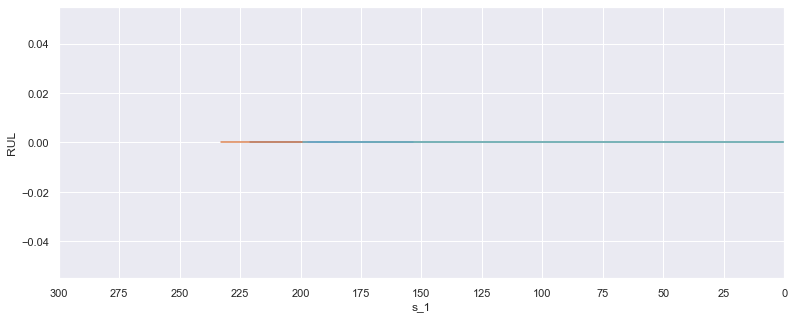

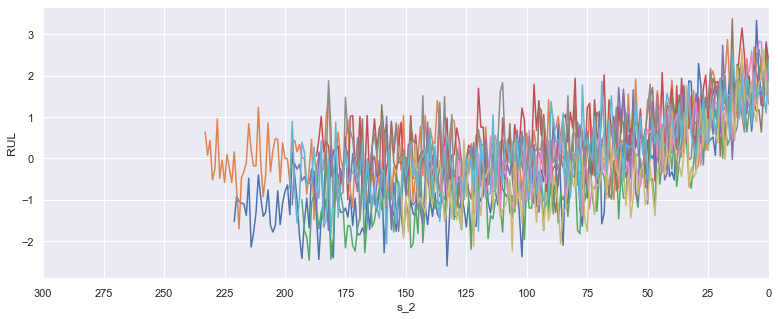

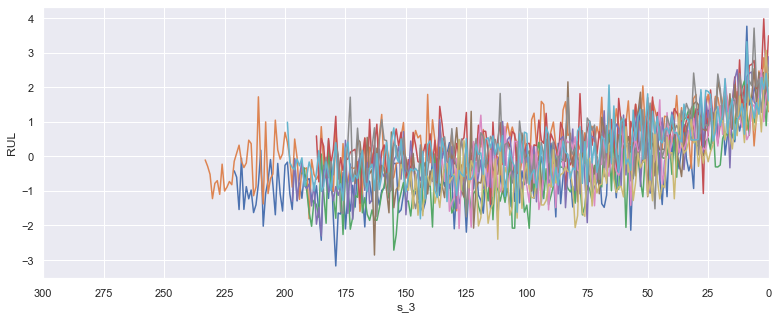

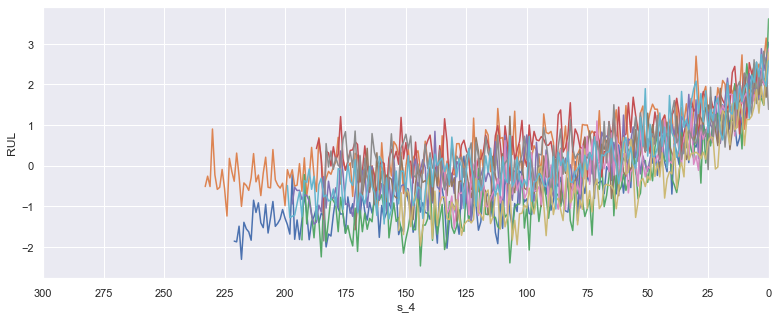

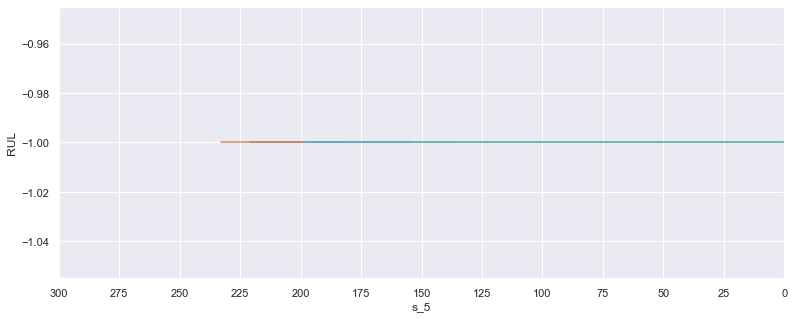

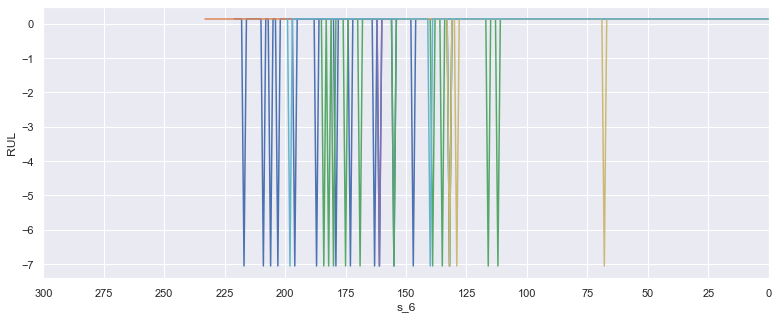

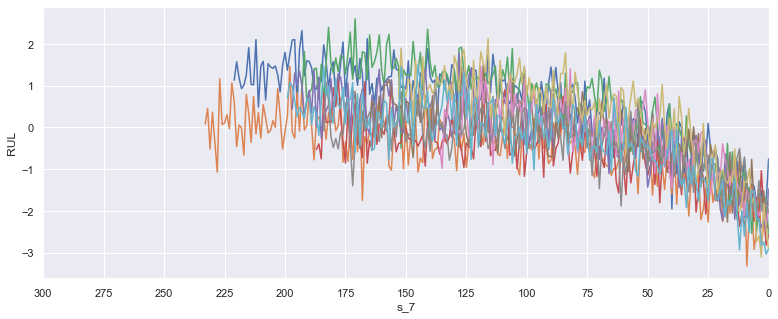

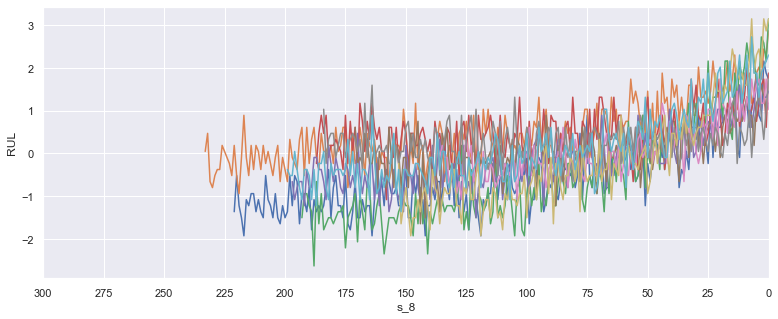

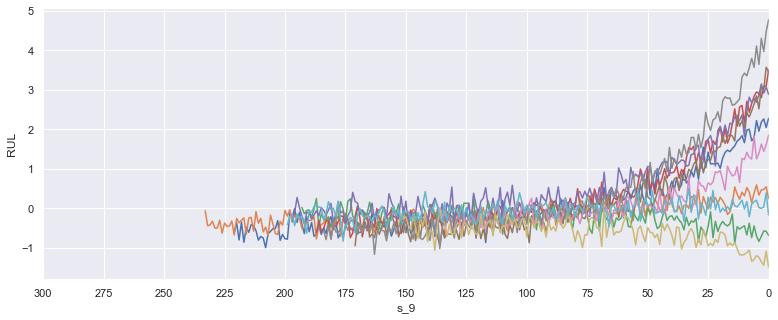

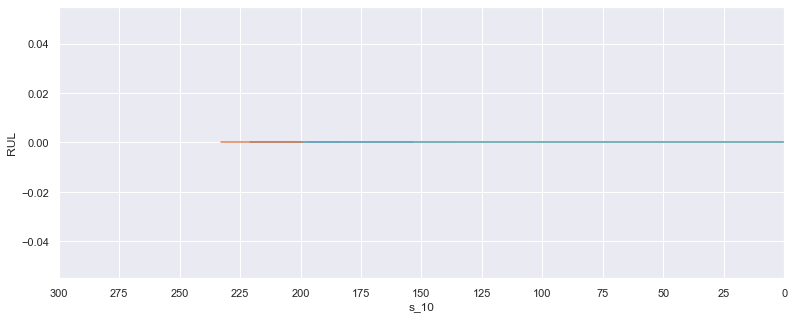

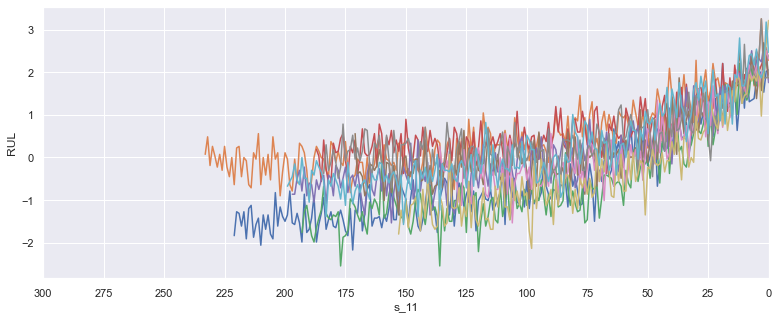

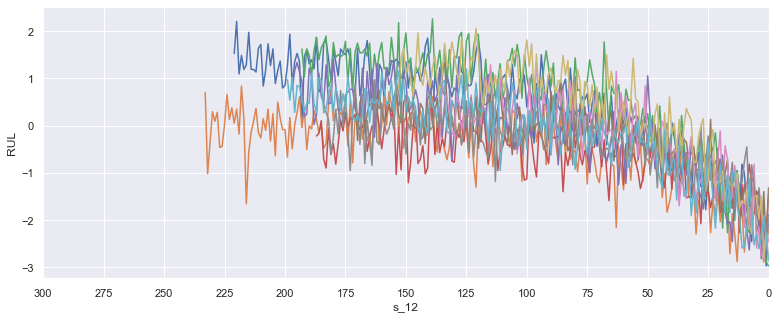

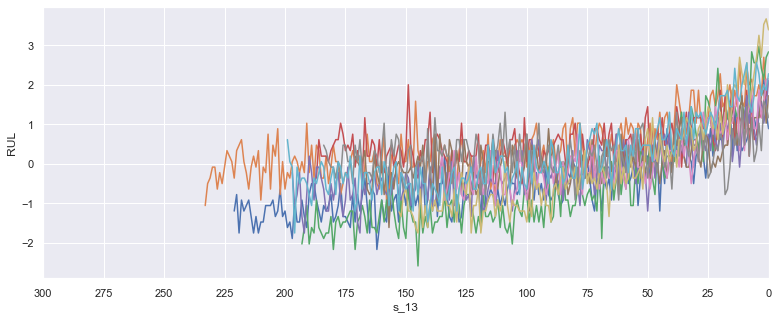

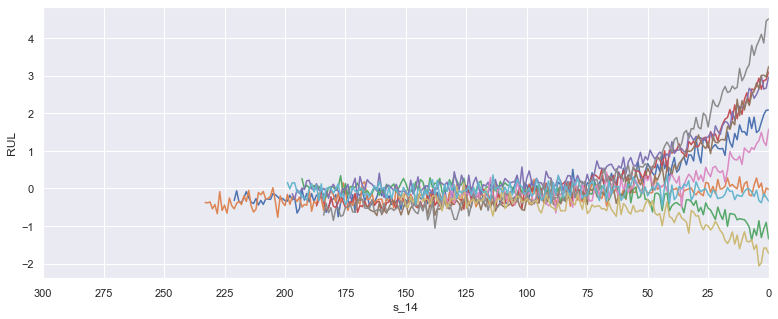

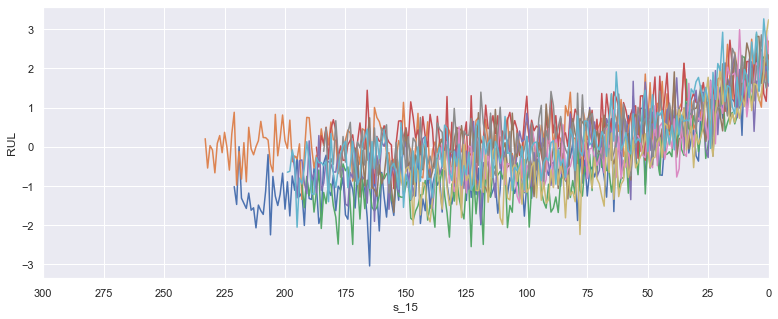

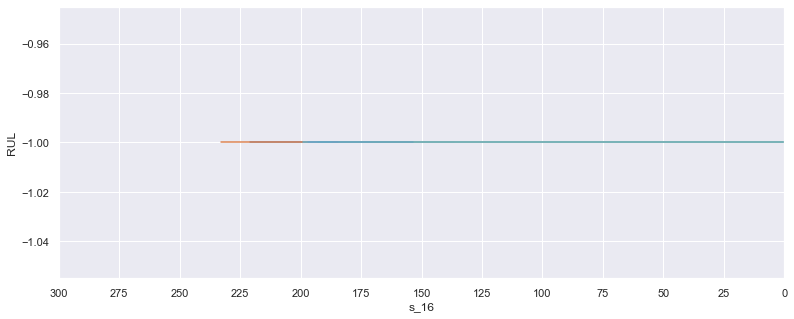

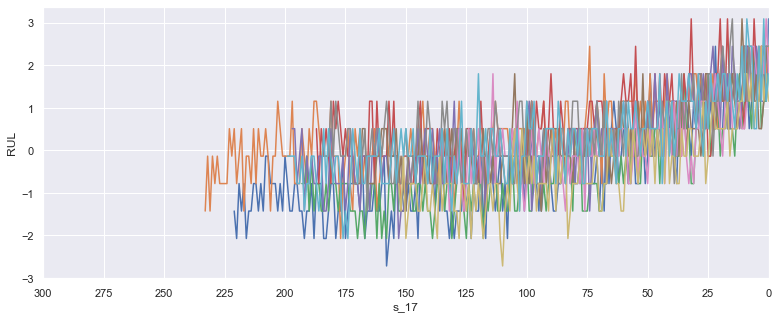

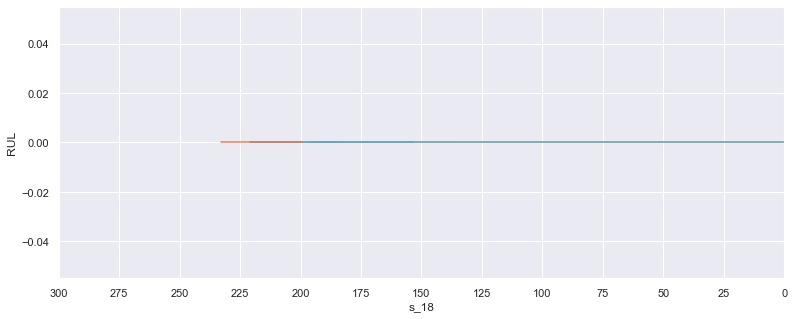

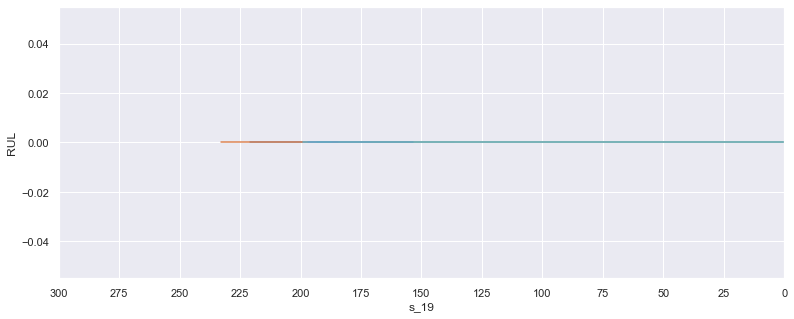

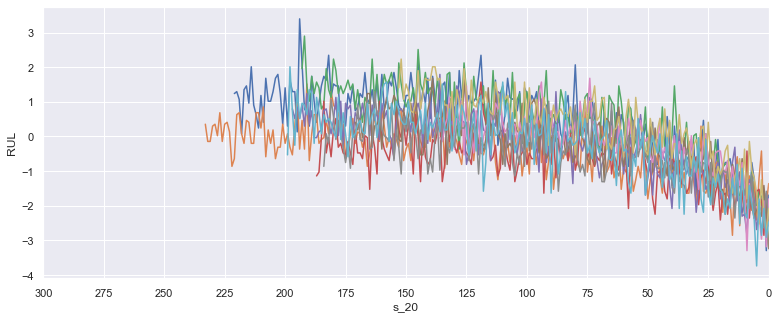

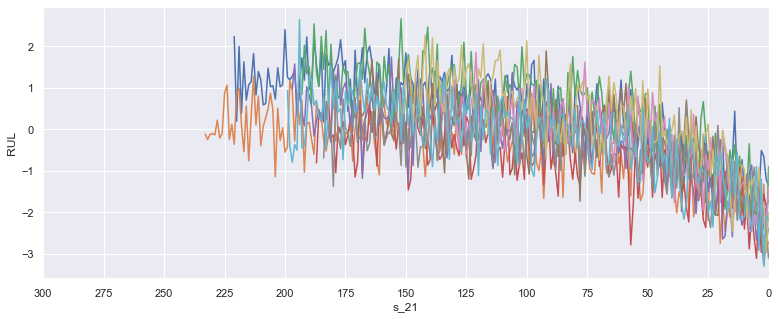

In [55]:
# plot each sensor to see if it seems useful at all

for sensor in sensor_names:
    plt.figure(figsize=(13,5))
    for i in train['unit_id'].unique():
        if (i % 10 == 0):
            plt.plot("RUL", sensor, data=X_train_scaled[X_train_scaled["unit_id"] == i])
    plt.xlim(300,0)
    plt.xlabel(sensor)
    plt.ylabel("RUL")
    plt.xticks(np.arange(0,325,25))
    plt.show()

Seonsors 1, 5, 6, 16, 18, and  seem to be pretty much just noise, so I am gonna drop em

In [56]:
drops = ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
keep = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

In [170]:
# need to format data for LSTM model. I did my best, this part is kinda hard.
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
# so first we need to set how long our sequence is going to be
# in theory this is something we can play around with
sequence_length = 50

# also, added some clipping so that I don't capture steady state operations, and instead we are looking at degredation
train['RUL'].clip(upper=125, inplace=True)

# next, drop the columns we ain't gonna be using
train_dropped = train.drop(drops, axis=1)
test_dropped = test.drop(drops, axis=1)

# now, add operating condition as a string we can use as a conditional variable
# basically just combine the settings into a single string

train_dropped_co = add_op_co(train_dropped)
test_dropped_co = add_op_co(test_dropped)

# next we need to standardize the data
scaler = StandardScaler()



# using the condition to standardize. Initially just tried scaling everything, but this actually worked the best
for co in train_dropped_co['op_cond'].unique():
    scaler.fit(train_dropped_co.loc[train_dropped_co['op_cond']==co, keep])
    train_dropped_co.loc[train_dropped_co['op_cond']==co, keep] = scaler.transform(train_dropped_co.loc[train_dropped_co['op_cond']==co, keep])
    test_dropped_co.loc[test_dropped_co['op_cond']==co, keep] = scaler.transform(test_dropped_co.loc[test_dropped_co['op_cond']==co, keep])

# regular old scalar
train_dropped_co_reg_st = train_dropped_co.copy()
test_dropped_co_reg_st = test_dropped_co.copy()
for i in keep:
    train_dropped_co_reg_st[keep] = scaler.fit_transform(train_dropped_co[keep])
    test_dropped_co_reg_st[keep] = scaler.fit_transform(test_dropped_co[keep])

# minmax, which is what Azure team did

train_dropped_co_reg_mm = train_dropped_co.copy()
test_dropped_co_reg_mm = test_dropped_co.copy()
minmax = MinMaxScaler()
for i in keep:
    train_dropped_co_reg_mm[keep] = minmax.fit_transform(train_dropped_co[keep])
    test_dropped_co_reg_mm[keep] = minmax.fit_transform(test_dropped_co[keep])

# need to now split into train and validation sets. GSS is a pretty neat way to do it, given that we need to keep units intact (i.e. sequences stay within engine)
train_u = []
val_u = []
for train_index, val_index in gss.split(train_dropped_co['unit_id'].unique(), groups=train_dropped_co['unit_id'].unique()):
    train_u = [train_index]
    val_u = [val_index]

# these are the units we are gonna use in each split
train_units = train_dropped_co['unit_id'].unique()[train_u]
val_units = test_dropped_co['unit_id'].unique()[val_u]
print(train_units)

# now we need to shape the data into arrays and then sequences for the LSTM
# tried to use tensorflow, but it does not have enough flexibility to make the sequences
# since we need to keep engine data together

# define our feature columns:
# couple different ways to look at it

features_just_senors = keep
features_with_settings = setting_names.extend(keep)

# use generator to make generator for each engine, then wrap them up into a single generator

# first make validation testing sets

train_split_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in train_units)
train_split = np.concatenate(list(train_split_gen)).astype(np.float32)

val_split_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in val_units)
val_split = np.concatenate(list(val_split_gen)).astype(np.float32)

# lstm aslo requires labels for each sequence, which needs to be generated
# label is essentially the thing we are trying to predict or classify
# in Azure study, they classified based on if the engine would fail within x cycles
# since we are trying to predict RUL, we will use RUL

train_labels_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in train_units]
train_labels = np.concatenate(list(train_labels_gen)).astype(np.float32)

val_labels_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in val_units]
val_labels = np.concatenate(list(val_labels_gen)).astype(np.float32)

# Lastly, lets get the data for making predictions, using the full available dataset

train_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in train_dropped_co["unit_id"].unique())
train_array = np.concatenate(list(train_gen)).astype(np.float32)

train_labels_out_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in train_dropped_co["unit_id"].unique()]
train_array_labels = np.concatenate(list(train_labels_out_gen)).astype(np.float32)

# and now we need the test data
# in order to get more test data, we can add padding to get more sequences
# padding idea inspired by --> https://towardsdatascience.com/lstm-for-predictive-maintenance-of-turbofan-engines-f8c7791353f3

test_gen = (list(test_padding(test_dropped_co[test_dropped_co["unit_id"]==u], sequence_length, features_just_senors, -99.)) for u in test_dropped_co["unit_id"].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

<ipython-input-170-f17461a5bfa2>:55: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_units = train_dropped_co['unit_id'].unique()[train_u]
<ipython-input-170-f17461a5bfa2>:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  val_units = test_dropped_co['unit_id'].unique()[val_u]


[  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  21  22  24
  25  26  27  28  29  30  33  35  36  37  38  39  41  42  43  44  47  48
  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  75  76  79  80  82  83  85  86  87  88  89  90  92
  93  94  95  96  97  98  99 100]


In [171]:


model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights_001.h5')

In [172]:
model.load_weights('simple_lstm_weights.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=5,
                   batch_size=32)

Epoch 1/5
396/396 [==============================] - 20s 37ms/step - loss: 96255008.0000 - val_loss: 87099.6484
Epoch 2/5
396/396 [==============================] - 14s 35ms/step - loss: 77657.5703 - val_loss: 67492.3047
Epoch 3/5
396/396 [==============================] - 14s 36ms/step - loss: 59763.2969 - val_loss: 54626.8008
Epoch 4/5
396/396 [==============================] - 14s 35ms/step - loss: 45672.8203 - val_loss: 38808.5117
Epoch 5/5
396/396 [==============================] - 14s 35ms/step - loss: 32919.6797 - val_loss: 28010.2109


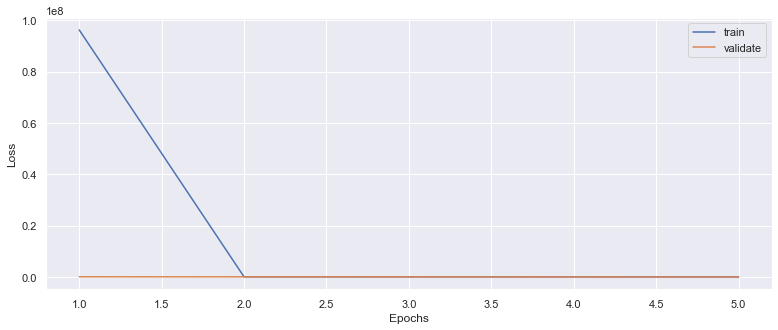

In [173]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [174]:

# predict and evaluate
y_hat_train = model.predict(train_array)
get_rmse(train_array_labels, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
get_rmse(y_test, y_hat_test)

Dataset: train RMSE:165.7970733642578, R2:-15.045116694448836
Dataset: test RMSE:133.11380676168102, R2:-9.260928532522756


In [176]:

model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('simple_lstm_weights_001_base.h5')

history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=20,
                   batch_size=32)

Epoch 1/20
396/396 [==============================] - 18s 39ms/step - loss: 96255008.0000 - val_loss: 87099.6484: 6 - ETA: 5s - l
Epoch 2/20
396/396 [==============================] - 15s 39ms/step - loss: 77657.5703 - val_loss: 67492.3047
Epoch 3/20
396/396 [==============================] - 14s 37ms/step - loss: 59763.2969 - val_loss: 54626.8008
Epoch 4/20
396/396 [==============================] - 15s 37ms/step - loss: 45672.8203 - val_loss: 38808.5117
Epoch 5/20
396/396 [==============================] - 15s 37ms/step - loss: 32919.6797 - val_loss: 28010.2109
Epoch 6/20
396/396 [==============================] - 15s 38ms/step - loss: 7008.3223 - val_loss: 1018.5171
Epoch 7/20
396/396 [==============================] - 14s 36ms/step - loss: 1522.1956 - val_loss: 711.3959
Epoch 8/20
396/396 [==============================] - 14s 35ms/step - loss: 680.7745 - val_loss: 498.6050
Epoch 9/20
396/396 [==============================] - 14s 35ms/step - loss: 516.8651 - val_loss: 336.7850
Epo

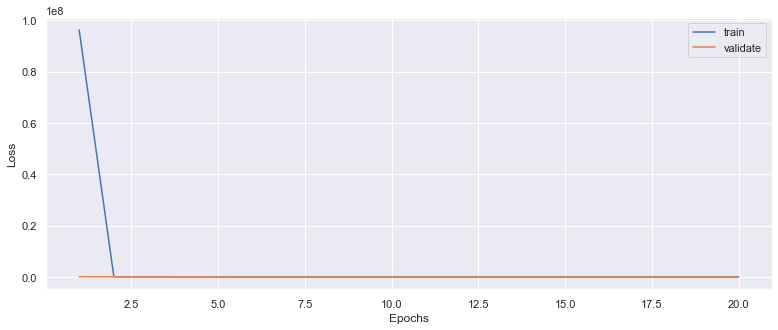

In [179]:
plot_loss(history)

In [180]:
y_hat_train = model.predict(train_array)
get_rmse(train_array_labels, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
get_rmse(y_test, y_hat_test)

Dataset: train RMSE:15.540021896362305, R2:0.8590411361881796
Dataset: test RMSE:17.571376170792384, R2:0.8212063837735689


### How to try different parameters?

In [140]:
def prep_data(train, test, drops, keep, features, scaling, sequence_length, lags=None):
    train_dropped = train.drop(drops, axis=1)
    test_dropped = test.drop(drops, axis=1)
    
    train_dropped_co = add_op_co(train_dropped)
    test_dropped_co = add_op_co(test_dropped)
    
    print(test_dropped_co["unit_id"].unique())
    
    if scaling == "conditional":
        scaler = StandardScaler()
        for co in train_dropped_co['op_cond'].unique():
            scaler.fit(train_dropped_co.loc[train_dropped_co['op_cond']==co, keep])
            train_dropped_co.loc[train_dropped_co['op_cond']==co, keep] = scaler.transform(train_dropped_co.loc[train_dropped_co['op_cond']==co, keep])
            test_dropped_co.loc[test_dropped_co['op_cond']==co, keep] = scaler.transform(test_dropped_co.loc[test_dropped_co['op_cond']==co, keep])
    elif scaling == "standard":
        scaler = StandardScaler()
        for i in keep:
            train_dropped_co[keep] = scaler.fit_transform(train_dropped_co[keep])
            test_dropped_co[keep] = scaler.fit_transform(test_dropped_co[keep])
    elif scaling == "minmax":
        minmax = MinMaxScaler()
        for i in keep:
            train_dropped_co[keep] = minmax.fit_transform(train_dropped_co[keep])
            test_dropped_co[keep] = minmax.fit_transform(test_dropped_co[keep])
    
    train_u = []
    val_u = []
    
    if lags:
        for i in lags:
            train_dropped_co = lag(train_dropped_co, i, keep)
            test_dropped_co = lag(test_dropped_co, i, keep)
        
    for train_index, val_index in gss.split(train_dropped_co['unit_id'].unique(), groups=train_dropped_co['unit_id'].unique()):
        train_u = [train_index]
        val_u = [val_index]
        
    
    
    train_units = train_dropped_co['unit_id'].unique()[train_u]
    val_units = test_dropped_co['unit_id'].unique()[val_u]
    
    train_split_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features)) for u in train_units)
    train_split = np.concatenate(list(train_split_gen)).astype(np.float32)
    
    val_split_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features)) for u in val_units)
    val_split = np.concatenate(list(val_split_gen)).astype(np.float32)
    
    train_labels_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in train_units]
    train_labels = np.concatenate(list(train_labels_gen)).astype(np.float32)

    val_labels_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in val_units]
    val_labels = np.concatenate(list(val_labels_gen)).astype(np.float32)

    train_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features)) for u in train_dropped_co["unit_id"].unique())
    train_array = np.concatenate(list(train_gen)).astype(np.float32)

    train_labels_out_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in train_dropped_co["unit_id"].unique()]
    train_array_labels = np.concatenate(list(train_labels_out_gen)).astype(np.float32)
    
    test_gen = (list(test_padding(test_dropped_co[test_dropped_co["unit_id"]==u], sequence_length, features, -99.)) for u in test_dropped_co["unit_id"].unique())
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    print(test_dropped_co["unit_id"].unique())
    return train_split, val_split, train_labels, val_labels, train_array, train_array_labels, test_array


In [114]:
# get column names for the lagged data set
train_dropped_co_lagged = train_dropped_co.copy()

for i in lags:
    train_dropped_co_lagged = lag(train_dropped_co_lagged, i, keep)
    
train_dropped_co_lagged.head()

features_with_lags = train_dropped_co_lagged.columns
features_with_lags = features_with_lags.drop(["unit_id", "time_cycles", "RUL", "op_cond", "setting_1", "setting_2", "setting_3"])
features_with_everything = train_dropped_co_lagged.columns
features_with_everything = features_with_everything.drop(["unit_id", "time_cycles", "RUL", "op_cond"])

In [103]:
# can we possibly do hyperparamaterization?
lags = [1,2,3,4,5,10,20]
sequences = [np.arange(10,45,5)]
epochs = [np.arange(5,30,5)]
nodes_list = [[50], [64], [128], [256], [32, 64], [64, 128], [50,100] [128, 256]]
dropouts = list(np.arange(1,5)/10)
function = ["sigmoid", "tanh", "relu"]
batch_size = [32, 64, 128, 256]
features = [features_just_senors, features_with_settings, features_with_lags, features_with_everything]
scaling = ["conditional", "scalar", "minmax"]
gss_params = [2,3]
data_set = [train_dropped_co, train_dropped_co_lagged]

# yikes thats a lot of things I could vary
tuning_params = len(lags)*len(sequences)*len(epochs)*len(nodes_list)*len(dropouts)*len(function)*len(batch_size)*len(features)*len(scaling)*len(gss_params)*len(dataset)
tuning_params

112896

In [188]:
## try shorter sequences
train_split, val_split, train_labels, val_labels, train_array, train_array_labels, test_array = prep_data(train, test, drops, keep, features_just_senors, "conditional", 20)

print(train_array.shape[0])

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


<ipython-input-140-143d5fcf42c3>:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_units = train_dropped_co['unit_id'].unique()[train_u]
<ipython-input-140-143d5fcf42c3>:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  val_units = test_dropped_co['unit_id'].unique()[val_u]


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
18731


Epoch 1/5
471/471 [==============================] - 11s 16ms/step - loss: 951.5099 - val_loss: 325.4869
Epoch 2/5
471/471 [==============================] - 7s 15ms/step - loss: 323.7994 - val_loss: 231.2838
Epoch 3/5
471/471 [==============================] - 7s 15ms/step - loss: 288.0957 - val_loss: 271.6266
Epoch 4/5
471/471 [==============================] - 7s 15ms/step - loss: 269.0638 - val_loss: 283.1372
Epoch 5/5
471/471 [==============================] - 7s 15ms/step - loss: 251.9469 - val_loss: 200.0231


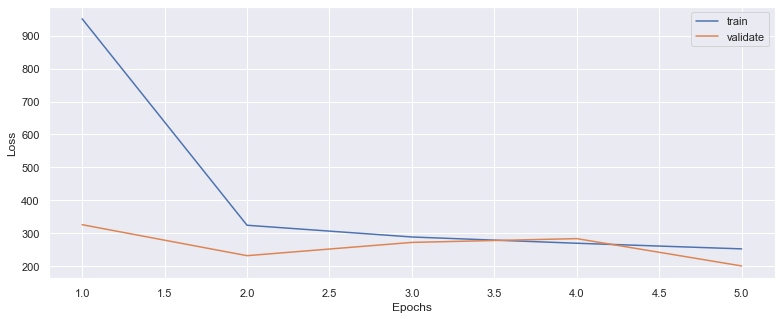

Dataset: train RMSE:14.750917434692383, R2:0.875729697626874
Dataset: test RMSE:17.92793578384452, R2:0.8138765767434594


In [185]:
## Build same model and test with 5 epochs

model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights_001_shorter_sequence.h5')

model.load_weights('simple_lstm_weights_001_shorter_sequence.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=5,
                   batch_size=32)
plot_loss(history)
y_hat_train = model.predict(train_array)
get_rmse(train_array_labels, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
get_rmse(y_test, y_hat_test)


Epoch 1/20
471/471 [==============================] - 7s 16ms/step - loss: 1438.6461 - val_loss: 313.4371
Epoch 2/20
471/471 [==============================] - 7s 16ms/step - loss: 344.0607 - val_loss: 256.3531
Epoch 3/20
471/471 [==============================] - 7s 15ms/step - loss: 298.8965 - val_loss: 298.3002
Epoch 4/20
471/471 [==============================] - 7s 15ms/step - loss: 275.3644 - val_loss: 260.1828
Epoch 5/20
471/471 [==============================] - 7s 15ms/step - loss: 263.4614 - val_loss: 257.3488
Epoch 6/20
471/471 [==============================] - 7s 15ms/step - loss: 251.8065 - val_loss: 227.2024
Epoch 7/20
471/471 [==============================] - 7s 16ms/step - loss: 236.2039 - val_loss: 252.7636
Epoch 8/20
471/471 [==============================] - 8s 16ms/step - loss: 232.7138 - val_loss: 225.8251
Epoch 9/20
471/471 [==============================] - 7s 15ms/step - loss: 214.6659 - val_loss: 210.4879
Epoch 10/20
471/471 [==============================] -

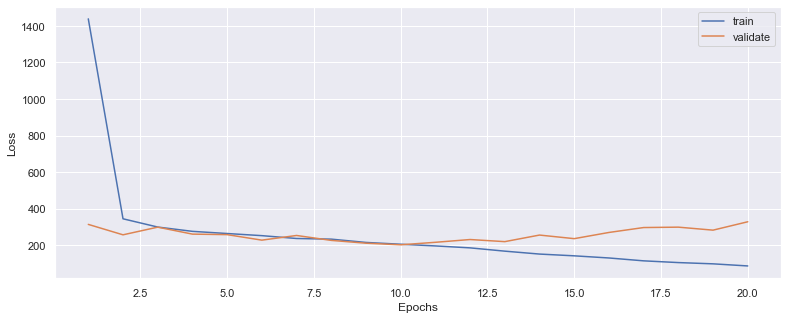

Dataset: train RMSE:11.917888641357422, R2:0.9188799956124813
Dataset: test RMSE:19.15709037312893, R2:0.7874801249820894


In [190]:
## Build same model and test with 20 epochs
model.load_weights('simple_lstm_weights_001_shorter_sequence.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=20,
                   batch_size=32)
plot_loss(history)
y_hat_train = model.predict(train_array)
get_rmse(train_array_labels, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
get_rmse(y_test, y_hat_test)


Thats a few too many parameters for my humble laptop to handle

In [214]:
# lets see if lagged does better

train_split, val_split, train_labels, val_labels, train_array, train_array_labels, test_array = prep_data(train, test, drops, keep, features_with_everything, "conditional", 50, lags)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


<ipython-input-140-143d5fcf42c3>:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_units = train_dropped_co['unit_id'].unique()[train_u]
<ipython-input-140-143d5fcf42c3>:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  val_units = test_dropped_co['unit_id'].unique()[val_u]


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


In [215]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights_001_50_lagged.h5')

In [216]:
model.load_weights('simple_lstm_weights_001_50_lagged.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=5,
                   batch_size=32)

Epoch 1/5
396/396 [==============================] - 19s 40ms/step - loss: 557290.8125 - val_loss: 721378.4375
Epoch 2/5
396/396 [==============================] - 16s 39ms/step - loss: 336597.2812 - val_loss: 42792.3438
Epoch 3/5
396/396 [==============================] - 16s 39ms/step - loss: 31399.4883 - val_loss: 32718.4434
Epoch 4/5
396/396 [==============================] - 15s 39ms/step - loss: 19719.7773 - val_loss: 18154.3477
Epoch 5/5
396/396 [==============================] - 16s 40ms/step - loss: 8746.7773 - val_loss: 8013.2271


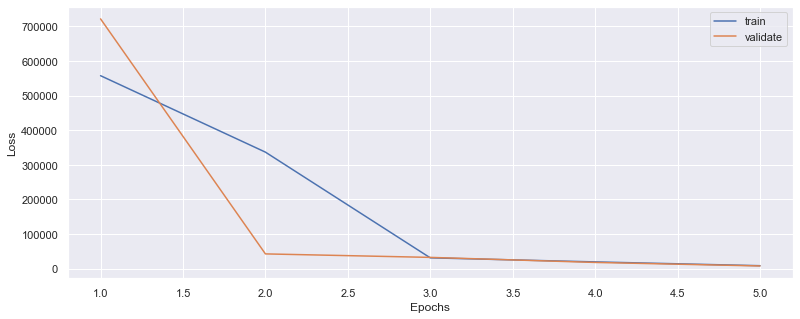

Dataset: train RMSE:82.25897979736328, R2:-2.9496240213979283
Dataset: test RMSE:60.10596221963165, R2:-1.0920668789049204


In [217]:
plot_loss(history)
# predict and evaluate
y_hat_train = model.predict(train_array)
get_rmse(train_array_labels, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
get_rmse(y_test, y_hat_test)

In [218]:

model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('simple_lstm_weights_001_50_lagged.h5')

history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=20,
                   batch_size=32)

Epoch 1/20
396/396 [==============================] - 19s 41ms/step - loss: 557290.8125 - val_loss: 721378.4375
Epoch 2/20
396/396 [==============================] - 16s 41ms/step - loss: 336597.2812 - val_loss: 42792.3438
Epoch 3/20
396/396 [==============================] - 15s 39ms/step - loss: 31399.4883 - val_loss: 32718.4434
Epoch 4/20
396/396 [==============================] - 15s 38ms/step - loss: 19719.7773 - val_loss: 18154.3477
Epoch 5/20
396/396 [==============================] - 15s 39ms/step - loss: 8746.7773 - val_loss: 8013.2271
Epoch 6/20
396/396 [==============================] - 15s 38ms/step - loss: 4515.6685 - val_loss: 4127.8027
Epoch 7/20
396/396 [==============================] - 15s 39ms/step - loss: 39268.3125 - val_loss: 104635.4609
Epoch 8/20
396/396 [==============================] - 15s 39ms/step - loss: 498126.3750 - val_loss: 120608.2109
Epoch 9/20
396/396 [==============================] - 15s 38ms/step - loss: 2625164.2500 - val_loss: 417926.5000
Epoch

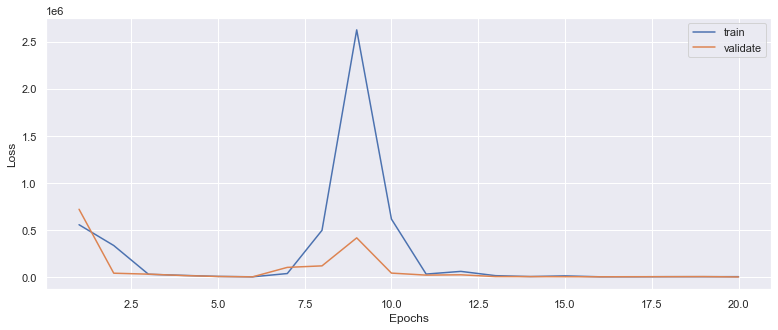

Dataset: train RMSE:57.897640228271484, R2:-0.9566399514194177
Dataset: test RMSE:57.77622999022798, R2:-0.9330311633743047


In [219]:
plot_loss(history)
y_hat_train = model.predict(train_array)
get_rmse(train_array_labels, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
get_rmse(y_test, y_hat_test)

In [220]:
## ok lagged did NOT do better on the 50 length sequence!!
# Let's try some hyper-parameter tuning
# there are something like 100,000 possible configurations for the model, and all I have is
# my poor lenovo here

# as inspired by the azure team and other examples, I'm gonna just try some random sampling
# of params and pick the best performing one

# for data, lets use _, which so far has worked the best
# keep sequence length at 50, as that's the goal




# so first we need to set how long our sequence is going to be
# in theory this is something we can play around with
sequence_length = 50

# also, added some clipping so that I don't capture steady state operations, and instead we are looking at degredation
train['RUL'].clip(upper=125, inplace=True)

# next, drop the columns we ain't gonna be using
train_dropped = train.drop(drops, axis=1)
test_dropped = test.drop(drops, axis=1)

# now, add operating condition as a string we can use as a conditional variable
# basically just combine the settings into a single string

train_dropped_co = add_op_co(train_dropped)
test_dropped_co = add_op_co(test_dropped)

# next we need to standardize the data
scaler = StandardScaler()



# using the condition to standardize. Initially just tried scaling everything, but this actually worked the best
for co in train_dropped_co['op_cond'].unique():
    scaler.fit(train_dropped_co.loc[train_dropped_co['op_cond']==co, keep])
    train_dropped_co.loc[train_dropped_co['op_cond']==co, keep] = scaler.transform(train_dropped_co.loc[train_dropped_co['op_cond']==co, keep])
    test_dropped_co.loc[test_dropped_co['op_cond']==co, keep] = scaler.transform(test_dropped_co.loc[test_dropped_co['op_cond']==co, keep])

# regular old scalar
train_dropped_co_reg_st = train_dropped_co.copy()
test_dropped_co_reg_st = test_dropped_co.copy()
for i in keep:
    train_dropped_co_reg_st[keep] = scaler.fit_transform(train_dropped_co[keep])
    test_dropped_co_reg_st[keep] = scaler.fit_transform(test_dropped_co[keep])

# minmax, which is what Azure team did

train_dropped_co_reg_mm = train_dropped_co.copy()
test_dropped_co_reg_mm = test_dropped_co.copy()
minmax = MinMaxScaler()
for i in keep:
    train_dropped_co_reg_mm[keep] = minmax.fit_transform(train_dropped_co[keep])
    test_dropped_co_reg_mm[keep] = minmax.fit_transform(test_dropped_co[keep])

# need to now split into train and validation sets. GSS is a pretty neat way to do it, given that we need to keep units intact (i.e. sequences stay within engine)
train_u = []
val_u = []
for train_index, val_index in gss.split(train_dropped_co['unit_id'].unique(), groups=train_dropped_co['unit_id'].unique()):
    train_u = [train_index]
    val_u = [val_index]

# these are the units we are gonna use in each split
train_units = train_dropped_co['unit_id'].unique()[train_u]
val_units = test_dropped_co['unit_id'].unique()[val_u]
print(train_units)

# now we need to shape the data into arrays and then sequences for the LSTM
# tried to use tensorflow, but it does not have enough flexibility to make the sequences
# since we need to keep engine data together

# define our feature columns:
# couple different ways to look at it

features_just_senors = keep
features_with_settings = setting_names.extend(keep)

# use generator to make generator for each engine, then wrap them up into a single generator

# first make validation testing sets

train_split_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in train_units)
train_split = np.concatenate(list(train_split_gen)).astype(np.float32)

val_split_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in val_units)
val_split = np.concatenate(list(val_split_gen)).astype(np.float32)

# lstm aslo requires labels for each sequence, which needs to be generated
# label is essentially the thing we are trying to predict or classify
# in Azure study, they classified based on if the engine would fail within x cycles
# since we are trying to predict RUL, we will use RUL

train_labels_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in train_units]
train_labels = np.concatenate(list(train_labels_gen)).astype(np.float32)

val_labels_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in val_units]
val_labels = np.concatenate(list(val_labels_gen)).astype(np.float32)

# Lastly, lets get the data for making predictions, using the full available dataset

train_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in train_dropped_co["unit_id"].unique())
train_array = np.concatenate(list(train_gen)).astype(np.float32)

train_labels_out_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in train_dropped_co["unit_id"].unique()]
train_array_labels = np.concatenate(list(train_labels_out_gen)).astype(np.float32)

# and now we need the test data
# in order to get more test data, we can add padding to get more sequences
# padding idea inspired by --> https://towardsdatascience.com/lstm-for-predictive-maintenance-of-turbofan-engines-f8c7791353f3

test_gen = (list(test_padding(test_dropped_co[test_dropped_co["unit_id"]==u], sequence_length, features_just_senors, -99.)) for u in test_dropped_co["unit_id"].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

<ipython-input-220-f17461a5bfa2>:55: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_units = train_dropped_co['unit_id'].unique()[train_u]
<ipython-input-220-f17461a5bfa2>:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  val_units = test_dropped_co['unit_id'].unique()[val_u]


[  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  21  22  24
  25  26  27  28  29  30  33  35  36  37  38  39  41  42  43  44  47  48
  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  75  76  79  80  82  83  85  86  87  88  89  90  92
  93  94  95  96  97  98  99 100]


In [226]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(.1))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights_001_50_2layer.h5')

In [230]:
model.load_weights('simple_lstm_weights_001_50_2layer.h5')

history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=20,
                   batch_size=32)

Epoch 1/20
396/396 [==============================] - 26s 65ms/step - loss: 7405.5225 - val_loss: 7212.7710
Epoch 2/20
396/396 [==============================] - 26s 66ms/step - loss: 7153.2783 - val_loss: 6041.5503
Epoch 3/20
396/396 [==============================] - 26s 66ms/step - loss: 508282432.0000 - val_loss: 1689385.2500
Epoch 4/20
396/396 [==============================] - 26s 65ms/step - loss: 4266134.5000 - val_loss: 617225.6250
Epoch 5/20
396/396 [==============================] - 26s 65ms/step - loss: 2323452.2500 - val_loss: 176642.2188
Epoch 6/20
396/396 [==============================] - 27s 69ms/step - loss: 1814090.8750 - val_loss: 108442.9531
Epoch 7/20
396/396 [==============================] - 26s 66ms/step - loss: 1173321.5000 - val_loss: 136705.2656
Epoch 8/20
396/396 [==============================] - 27s 69ms/step - loss: 824902.1875 - val_loss: 53142.2148
Epoch 9/20
396/396 [==============================] - 28s 71ms/step - loss: 589502.0000 - val_loss: 34552

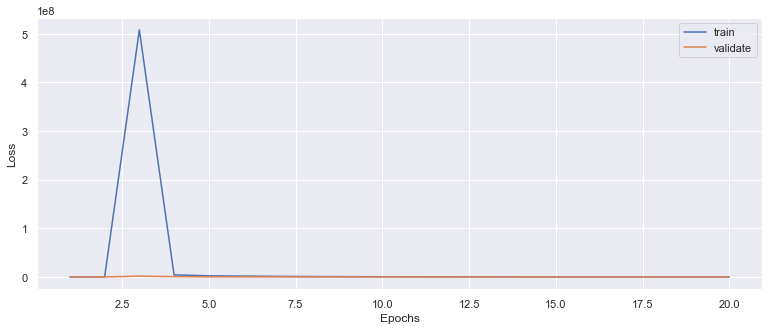

Dataset: train RMSE:58.844295501708984, R2:-1.0211468877492988
Dataset: test RMSE:58.2843161559965, R2:-0.9671789403045574


In [231]:
plot_loss(history)
y_hat_train = model.predict(train_array)
get_rmse(train_array_labels, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
get_rmse(y_test, y_hat_test)

In [159]:
# params to vary:


itterations = 20

epochs = [np.arange(10,40,5)]
nodes_list = [[50], [75], [100], [200], [50,100], [150, 250]]
dropouts = list(np.arange(1,5)/10)
function = ["sigmoid", "tanh", "relu"]

total_options = len(epochs)* len(nodes_list)*len(dropouts)* len(function)

ouput = []

# use the original block for building the sequences

for i in interations:
    
    model = Sequential()
    model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
    model.add(LSTM(node, activation=fun)
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=20,
                   batch_size=32)
    
    y_hat_train = model.predict(train_array)
    get_rmse(train_array_labels, y_hat_train, 'train')

    y_hat_test = model.predict(test_array)
    get_rmse(y_test, y_hat_test)
              
    output.append([[i],[node,fun,]])
    
              
    

array([ -0.29954594,  -0.5189061 ,  -1.2734185 ,   1.1407589 ,
        -1.1057968 ,  -0.66674393,  -1.0398661 ,   0.81735575,
        -0.52708834,  -0.57822937,  -1.1863909 ,  -1.4449906 ,
         1.6354462 ,   0.902063  ,  -1.2837925 ,  -1.5535265 ,
        -0.54876447,   1.4747077 ,  -0.7685194 ,  -0.6313945 ,
        -1.1498686 ,   0.71398854,  -0.47385418,  -0.61282736,
        -1.328234  ,  -1.4011267 ,   1.3313237 ,   0.6450982 ,
        -1.2108045 ,  -0.85120183,  -1.1261113 ,   1.0223006 ,
        -0.7980059 ,  -0.6050612 ,  -1.4843837 ,   0.7862999 ,
        -0.49971953,  -0.50860536,  -0.8589509 ,  -1.4317232 ,
         0.29733783,   0.84794044,  -1.6143086 ,   0.448514  ,
         0.38801685,   1.2692591 ,  -0.5180851 ,  -0.7606057 ,
        -0.6413795 ,   0.85004276,  -0.6507439 ,  -0.5079067 ,
        -0.18764302,  -1.4330988 ,   1.5835272 ,   1.4975886 ,
        -0.27886385,  -1.5766822 ,  -0.87868047,   0.22770452,
        -0.62851447,  -0.57555085,  -1.225082  ,   0.90

### Best Model

Epoch 1/20
396/396 [==============================] - 18s 36ms/step - loss: 7577.4214 - val_loss: 7016.9863
Epoch 2/20
396/396 [==============================] - 13s 32ms/step - loss: 35846692.0000 - val_loss: 10748.8145
Epoch 3/20
396/396 [==============================] - 13s 33ms/step - loss: 8955.6582 - val_loss: 7476.7422
Epoch 4/20
396/396 [==============================] - 13s 33ms/step - loss: 8376.9775 - val_loss: 7364.4956
Epoch 5/20
396/396 [==============================] - 13s 32ms/step - loss: 7948.9248 - val_loss: 7291.3521
Epoch 6/20
396/396 [==============================] - 12s 31ms/step - loss: 8004.1929 - val_loss: 7191.3843
Epoch 7/20
396/396 [==============================] - 12s 31ms/step - loss: 7693.2241 - val_loss: 7067.7144
Epoch 8/20
396/396 [==============================] - 13s 33ms/step - loss: 7350.8818 - val_loss: 6997.3037
Epoch 9/20
396/396 [==============================] - 13s 33ms/step - loss: 7243.8706 - val_loss: 6939.4946
Epoch 10/20
396/396 [==

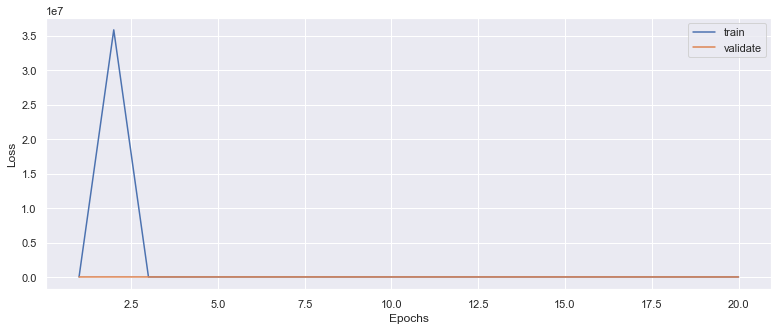

Dataset: train RMSE:79.07423400878906, R2:-2.64971618424145
Dataset: test RMSE:79.73451350923274, R2:-2.6815707709221477


In [232]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=20,
                   batch_size=32)
plot_loss(history)
y_hat_train = model.predict(train_array)
get_rmse(train_array_labels, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
get_rmse(y_test, y_hat_test)